In [37]:
import warnings
warnings.filterwarnings('ignore')
from fastai.vision.all import *
from pathlib import Path
import requests
from PIL import Image
import io

CLOUD_TYPES = ['cirrus', 'cumulus', 'stratus', 'nimbus']

In [38]:
def download_cloud_images(cloud_type, num_images=100):
    
    from ddgs import DDGS
    
    path = Path('cloud_data') / cloud_type
    path.mkdir(parents=True, exist_ok=True)
    
    ddgs = DDGS()
    results = ddgs.images(
        query=f"{cloud_type} clouds",
        max_results=num_images
    )
    
    for i, result in enumerate(results):
        try:
            img_url = result['image']
            response = requests.get(img_url, timeout=10)
            img = Image.open(io.BytesIO(response.content))
            img.save(path / f"{cloud_type}_{i}.jpg")
        except Exception as e:
            print(f"Failed to download image {i}: {e}")
            continue
    
    print(f"Downloaded images for {cloud_type}")


In [39]:
def prepare_data():
    
    for cloud_type in CLOUD_TYPES:
        download_cloud_images(cloud_type, num_images=150)

def create_dataloader():
    
    path = Path('cloud_data')
    
    dls = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(224),
        batch_tfms=aug_transforms(
            mult=2.0,
            do_flip=True,
            flip_vert=True,
            max_rotate=20.0,
            max_lighting=0.4,
            max_warp=0.4,
            p_affine=0.75,
            p_lighting=0.75
        )
    ).dataloaders(path, bs=32)
    
    return dls

In [40]:
def train_model(dls, epochs=10):
    
    learn = vision_learner(
        dls, 
        resnet34, 
        metrics=[error_rate, accuracy]
    )
    
    print("\nTraining model")
    learn.fine_tune(epochs)
    
    return learn

In [41]:
def evaluate_model(learn):
    
    print("\nModel Evaluation ")
    interp = ClassificationInterpretation.from_learner(learn)
    
    # Show confusion matrix
    interp.plot_confusion_matrix(figsize=(8, 8))
    
    # Show top losses
    interp.plot_top_losses(9, figsize=(15, 10))
    
    return interp

In [42]:
def predict_cloud_type(learn, img_path):
    
    pred, pred_idx, probs = learn.predict(img_path)
    
    print(f"\nPrediction: {pred}")
    print(f"Confidence: {probs[pred_idx]:.4f}")
    print("\nAll probabilities:")
    for i, cloud_type in enumerate(learn.dls.vocab):
        print(f"  {cloud_type}: {probs[i]:.4f}")
    
    return pred, probs

def export_model(learn, export_path='cloud_classifier.pkl'):
    
    learn.export(export_path)
    print(f"Model exported to {export_path}")

def load_and_predict(model_path, img_path):
    
    learn = load_learner(model_path)
    return predict_cloud_type(learn, img_path)


In [43]:
def verify_images(path):
    
    from fastai.vision.all import verify_images
    
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink) 
    print(f"Removed {len(failed)} corrupted images")

Failed to download image 0: cannot identify image file <_io.BytesIO object at 0x7eca6a38d8a0>
Failed to download image 6: cannot identify image file <_io.BytesIO object at 0x7eca7bf8ca90>
Failed to download image 9: HTTPSConnectionPool(host='cdn.zmescience.com', port=443): Max retries exceeded with url: /wp-content/uploads/2017/07/8690313402_5f76f736b3_k-1.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1016)')))
Failed to download image 10: cannot identify image file <_io.BytesIO object at 0x7eca6a76ddf0>
Failed to download image 14: cannot identify image file <_io.BytesIO object at 0x7eca7bf8cf40>
Failed to download image 15: cannot identify image file <_io.BytesIO object at 0x7eca6a31f330>
Failed to download image 23: HTTPSConnectionPool(host='cdn.zmescience.com', port=443): Max retries exceeded with url: /wp-content/uploads/2023/08/cirrus-clouds-2.webp (Caused by SSLError

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.143216,1.143536,0.405405,0.594595,01:06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.866651,0.961625,0.364865,0.635135,01:27
1,1.826904,0.863757,0.364865,0.635135,01:28
2,1.786717,0.855276,0.324324,0.675676,01:27
3,1.742255,0.928330,0.324324,0.675676,01:26
4,1.740351,1.022517,0.364865,0.635135,01:27
5,1.673748,0.909561,0.324324,0.675676,01:27
6,1.653173,0.927740,0.310811,0.689189,01:26
7,1.579432,0.927254,0.297297,0.702703,01:27
8,1.528659,0.950581,0.310811,0.689189,01:27
9,1.518302,0.932293,0.297297,0.702703,01:26



Evaluating model

Model Evaluation 


Model exported to cloud_classifier.pkl

Example Prediction


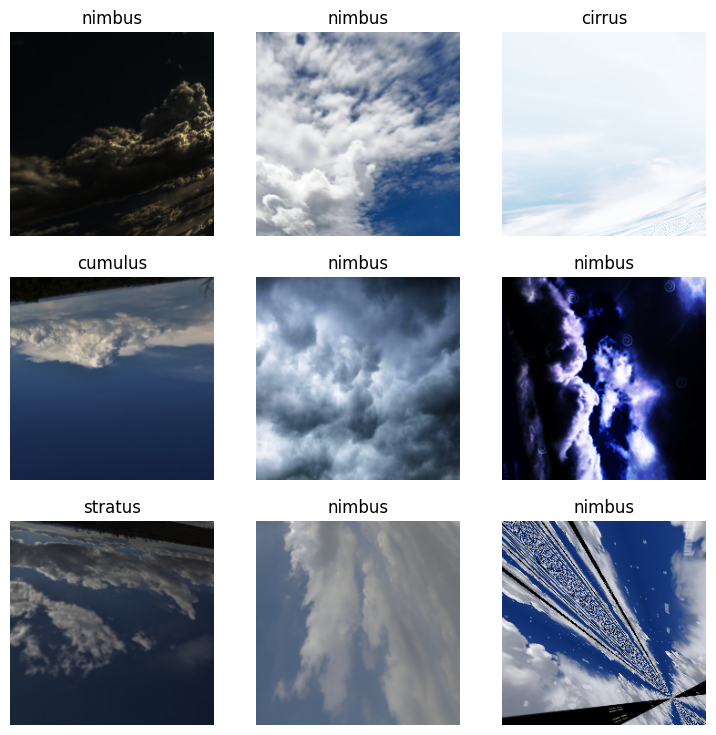

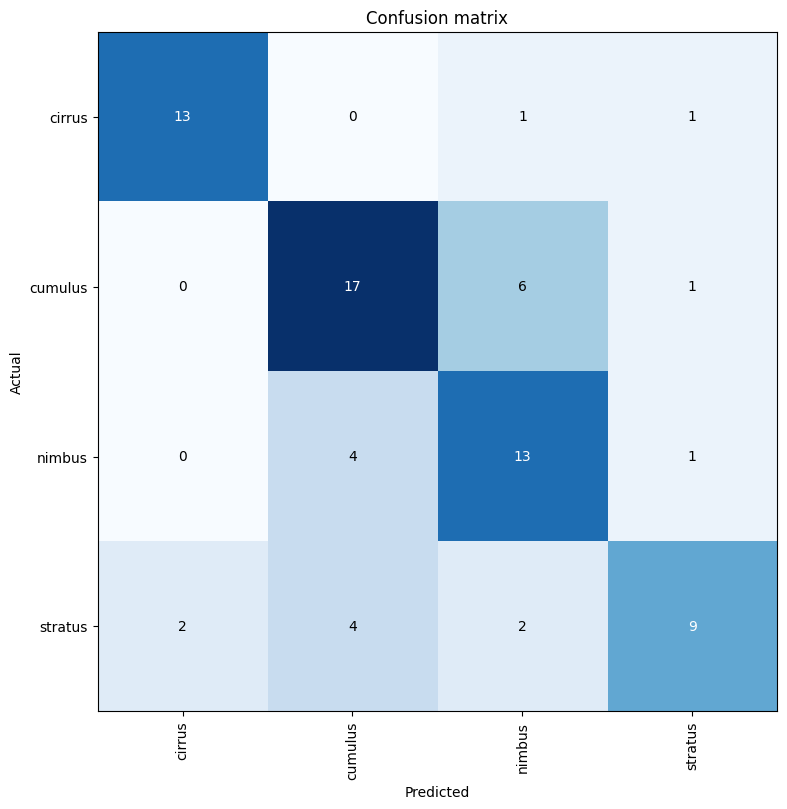

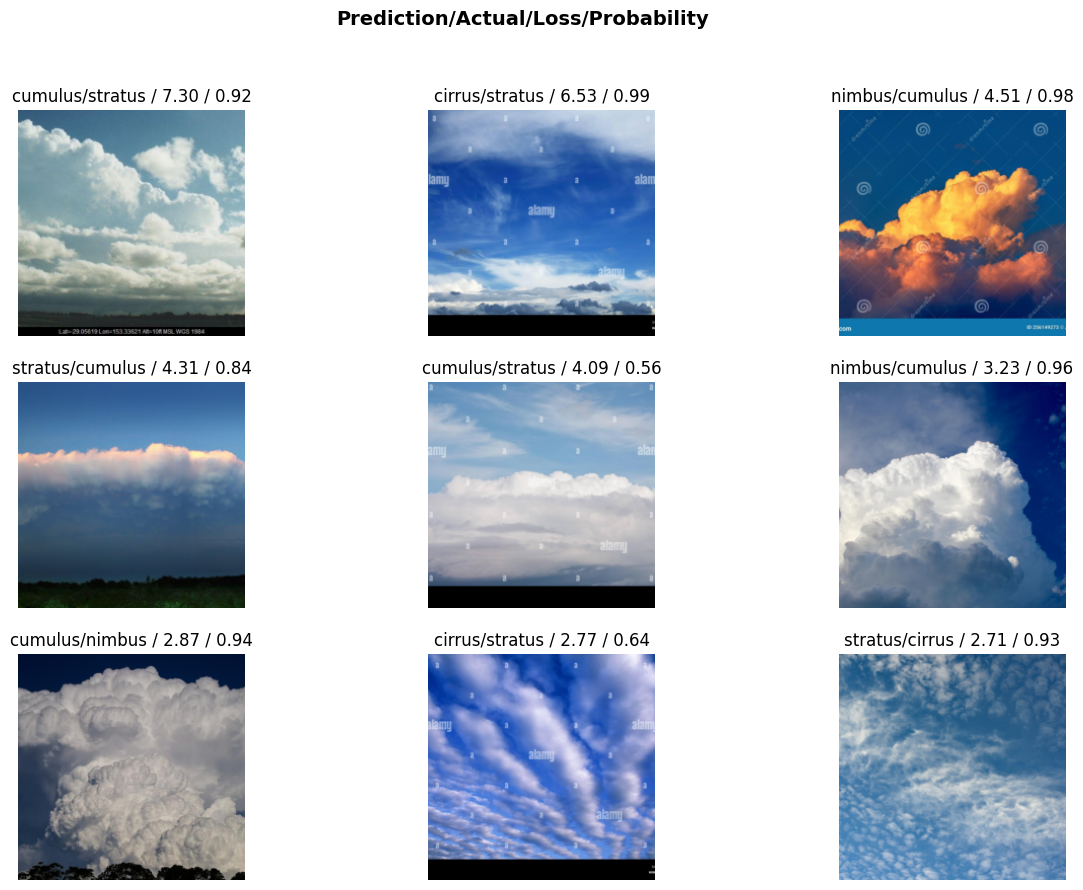

In [44]:

if __name__ == "__main__":
    print("Downloading cloud images")
    prepare_data()

    print("\nVerifying and cleaning images")
    verify_images(Path('cloud_data'))
    
    print("\nCreating dataloaders")
    dls = create_dataloader()
    dls.show_batch(max_n=9)
    
    print("\nTraining model")
    learn = train_model(dls, epochs=10)
    
    print("\nEvaluating model")
    interp = evaluate_model(learn)
    
    export_model(learn)
    
    print("\nExample Prediction")
    test_image = Path('cloud_data/cumulus/cumulus_0.jpg')
    if test_image.exists():
        predict_cloud_type(learn, test_image)
